# Improving DCA for Bitcoin Accumulation

Welcome to the first tutorial notebook for the [**Hypertrial Stacking Sats Challenge**](https://www.hypertrial.ai/trading-arena/challenge/bitcoin). By the end of this notebook, you should understand:

1. The pros of Bitcoin Dollar Cost Averaging (DCA)  
2. The cons of Bitcoin DCA  
3. How to implement dynamic DCA strategies

# Imports

If any package fails to import, install it inline using:
```bash
!pip install <package_name>

In [1]:
import pandas as pd
from datetime import datetime
from coinmetrics.api_client import CoinMetricsClient
import logging

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

# Data

For simplicity, this notebook uses historical Bitcoin price data from CoinMetrics to define a Dynamic DCA strategy. Future notebooks will explore more advanced approaches that incorporate additional data sources.

In [3]:
# Configure logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Initialize Coin Metrics API client
client = CoinMetricsClient()

# Define the asset, metric, and time range
asset = 'btc'
metric = 'PriceUSD'
start_time = '2010-01-01'
end_time = datetime.today().strftime('%Y-%m-%d')  # Set end_time to today's date
frequency = '1d'

# Fetch the metric data for the specified asset and time range
logging.info("Fetching BTC ReferenceRate...")
btc_df = client.get_asset_metrics(
    assets=asset,
    metrics=[metric],
    frequency=frequency,
    start_time=start_time,
    end_time=end_time
).to_dataframe()

# Rename the 'ReferenceRate' column to 'Close'
btc_df = btc_df.rename(columns={metric: 'Close'})

# Set 'time' as the index and normalize to remove the time component but keep it as a DatetimeIndex
btc_df['time'] = pd.to_datetime(btc_df['time']).dt.normalize()

# Remove timezone information, if any
btc_df['time'] = btc_df['time'].dt.tz_localize(None)

# Set 'time' as the index
btc_df.set_index('time', inplace=True)

# Only keep close data
btc_df = btc_df[['Close']]

# Rename "Close" TO "BTC"
btc_df = btc_df.rename(columns={"Close": "btc_close"})

# Display
btc_df.info()
btc_df

2025-03-21 19:52:13 INFO     Fetching BTC ReferenceRate...
2025-03-21 19:52:16 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-03-21 19:52:23 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits
2025-03-21 19:52:31 INFO     Sleeping for a rate limit window because 429 (too many requests) error was returned. Pleasesee Coin Metrics APIV4 documentation for more information: https://docs.coinmetrics.io/api/v4/#tag/Rate-limits


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5361 entries, 2010-07-18 to 2025-03-21
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   btc_close  5361 non-null   Float64
dtypes: Float64(1)
memory usage: 89.0 KB


,btc_close
time,
2010-07-18,0.08584
2010-07-19,0.0808
2010-07-20,0.074736
2010-07-21,0.079193
2010-07-22,0.05847
...,...
2025-03-17,84013.947518
2025-03-18,82680.806551
2025-03-19,86774.235072


# Bitcoin DCA (The Standard, "Uniform" Approach)

Dollar Cost Averaging (DCA) is a popular approach where you invest a fixed amount at regular intervals. This strategy reduces timing risk and emotional biases by smoothing out volatility. But if Bitcoin DCA isn’t broken, why fix it? In this section, we’ll quantify the **opportunity cost** of Bitcoin DCA by comparing its Satoshis-per-dollar (spd) against the **best-case** (buying at the yearly low) and **worst-case** (buying at the yearly high) scenarios over a 1-year window. For convenience, we use a \$100,000 yearly budget, though the results are effectively budget-invariant.

$$\text{spd} = \left(\frac{1}{\text{BTC/USD}}\right) \times 100{,}000{,}000$$

> **Note**: 100,000,000 Satoshis is equal to 1 BTC. 


Because spd values can vary significantly over time, we convert them to a percentile to better visualize how much value a uniform DCA strategy captures relative to the extreme cases:


$$\text{spd\_pct} = \left(\frac{\text{strategy\_spd} - \text{worst\_spd}}{\text{best\_spd} - \text{worst\_spd}}\right) \times 100$$

> **Note**: The \$100,000 budget is chosen for illustrative clarity. Since spd is normalized, the absolute budget size does not affect these results unless you consider market slippage for very large buys (outside the scope of this challenge).

Below is a visualization comparing the **uniform DCA spd**, **best-case spd**, and **worst-case spd**, along with the **uniform DCA spd percentile**. Afterward, we’ll discuss the pros and cons of where Bitcoin DCA lands within that percentile range.

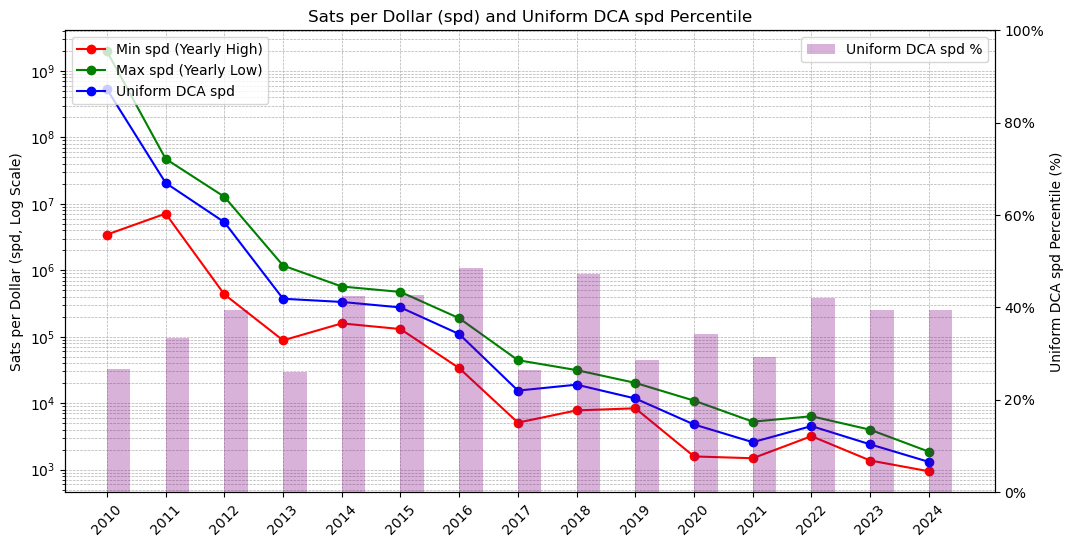

In [5]:
# Ensure the index is in datetime format
btc_df.index = pd.to_datetime(btc_df.index)

# Define the yearly cycle
cycle_length = pd.DateOffset(years=1)
start_date = btc_df.index.min()
end_date = btc_df.index.max()

# Budget per year
budget = 100_000

# Initialize lists for storing values
cycle_labels = []
min_spd_list = []      # spd when buying at yearly high (worst-case)
max_spd_list = []      # spd when buying at yearly low (best-case)
uniform_spd_list = []  # Uniform DCA spd value
uniform_spd_pct_list = []  # Normalized percentile for Uniform DCA

# Loop through each yearly cycle
current_start = start_date
while current_start <= end_date:
    current_end = min(current_start + cycle_length, end_date)
    cycle_df = btc_df.loc[current_start:current_end]
    
    if cycle_df.empty:
        break

    # Yearly high and low prices
    year_high = cycle_df['btc_close'].max()  # Worst-case price (yearly high)
    year_low = cycle_df['btc_close'].min()     # Best-case price (yearly low)

    # Calculate spd values (sats per dollar)
    min_spd_val = (1 / year_high) * 100_000_000  # Minimum spd (buying at highest price)
    max_spd_val = (1 / year_low) * 100_000_000     # Maximum spd (buying at lowest price)

    # Uniform DCA: Spend equal amount per day
    dca_amount_per_day = budget / len(cycle_df)
    btc_dca_accumulated = (dca_amount_per_day / cycle_df['btc_close']).sum()
    uniform_spd = (btc_dca_accumulated / budget) * 100_000_000

    # Normalize to get spd percentile for Uniform DCA:
    # 0% => spd = min_spd_val (worst-case); 100% => spd = max_spd_val (best-case)
    uniform_pct = ((uniform_spd - min_spd_val) / (max_spd_val - min_spd_val)) * 100

    # Store values for plotting
    cycle_labels.append(current_start.year)
    min_spd_list.append(min_spd_val)
    max_spd_list.append(max_spd_val)
    uniform_spd_list.append(uniform_spd)
    uniform_spd_pct_list.append(uniform_pct)

    # Move to next cycle
    current_start += cycle_length

# Plot the spd values and uniform spd percentile on a shared x-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary Y-axis: spd values on a log scale
ax1.set_yscale("log")
ax1.plot(cycle_labels, min_spd_list, marker='o', linestyle='-', label="Min spd (Yearly High)", color='red')
ax1.plot(cycle_labels, max_spd_list, marker='o', linestyle='-', label="Max spd (Yearly Low)", color='green')
ax1.plot(cycle_labels, uniform_spd_list, marker='o', linestyle='-', label="Uniform DCA spd", color='blue')
ax1.set_ylabel("Sats per Dollar (spd, Log Scale)")
ax1.set_title("Sats per Dollar (spd) and Uniform DCA spd Percentile")
ax1.legend(loc="upper left")
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.set_xticks(cycle_labels)
ax1.set_xticklabels(cycle_labels, rotation=45)

# Secondary Y-axis: Uniform DCA spd Percentile (0 to 100)
ax2 = ax1.twinx()
bar_width = 0.4
ax2.bar(
    [x + bar_width/2 for x in cycle_labels],
    uniform_spd_pct_list,
    width=bar_width,
    alpha=0.3,
    color='purple',
    label="Uniform DCA spd %"
)
ax2.set_ylabel("Uniform DCA spd Percentile (%)")
ax2.set_ylim(0, 100)
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax2.legend(loc="upper right")

plt.show()

**Uniform DCA SPD Percentile Explanation**

- **Pro (Distance from 0%)**  
  The higher the percentile, the further you are from the worst-case scenario (buying at the yearly high). By regularly buying throughout the year, you avoid concentrating your purchases at the highest possible price and smooth out volatility.

- **Con (Distance from 100%)**  
  The lower the percentile, the further you are from the best-case scenario (buying at the yearly low). A uniform schedule doesn’t let you capitalize aggressively on market dips, meaning you miss some potential upside compared to a more adaptive strategy. This gap represents the “opportunity cost” or missed upside that a more adaptive strategy could potentially capture.

Despite these drawbacks, **DCA remains attractive** for its simplicity and discipline. The key question is: **Can we preserve the core benefits of DCA—regular, systematic purchases and reduced emotional bias—while tailoring our buy amounts to better exploit Bitcoin’s unique structural characteristics?**

In the following section, we’ll **generalize the (uniform) DCA approach** into a dynamic accumulation strategy (dynamic dca) that still operates on a set budget and timeframe, but allows **variable buy amounts** based on a specific signal or thresholds. The goal is to keep the time diversification and discipline of DCA, while seeking to improve the overall sats per dollar (spd) captured by tailoring the strategy to Bitcoin's characteristics.

# Toward Dynamic Accumulation Strategies (Dynamic DCA)

One practical approach is to use a moving average signal—in this case, the 200-day moving average—to determine when Bitcoin is undervalued. The idea is simple: when Bitcoin's current price is below its 200-day moving average, it signals a discount relative to its long-term trend, so the strategy increases the buying weight. Otherwise, it defaults to the regular, uniform DCA.

Year 2010: Uniform ROI = 7148.20%, Dynamic ROI = 8576.01%, ROI Improvement = 1427.80%
Year 2011: Uniform ROI = 87.75%, Dynamic ROI = 98.13%, ROI Improvement = 10.38%
Year 2012: Uniform ROI = 349.67%, Dynamic ROI = 388.21%, ROI Improvement = 38.55%
Year 2013: Uniform ROI = 134.96%, Dynamic ROI = 140.81%, ROI Improvement = 5.84%
Year 2014: Uniform ROI = -7.53%, Dynamic ROI = -6.32%, ROI Improvement = 1.21%
Year 2015: Uniform ROI = 86.22%, Dynamic ROI = 93.68%, ROI Improvement = 7.46%
Year 2016: Uniform ROI = 152.24%, Dynamic ROI = 166.92%, ROI Improvement = 14.67%
Year 2017: Uniform ROI = 13.92%, Dynamic ROI = 15.59%, ROI Improvement = 1.67%
Year 2018: Uniform ROI = 102.44%, Dynamic ROI = 112.74%, ROI Improvement = 10.30%
Year 2019: Uniform ROI = 7.76%, Dynamic ROI = 9.90%, ROI Improvement = 2.14%
Year 2020: Uniform ROI = 51.21%, Dynamic ROI = 58.90%, ROI Improvement = 7.68%
Year 2021: Uniform ROI = -42.37%, Dynamic ROI = -39.28%, ROI Improvement = 3.10%
Year 2022: Uniform ROI = 34.63%, 

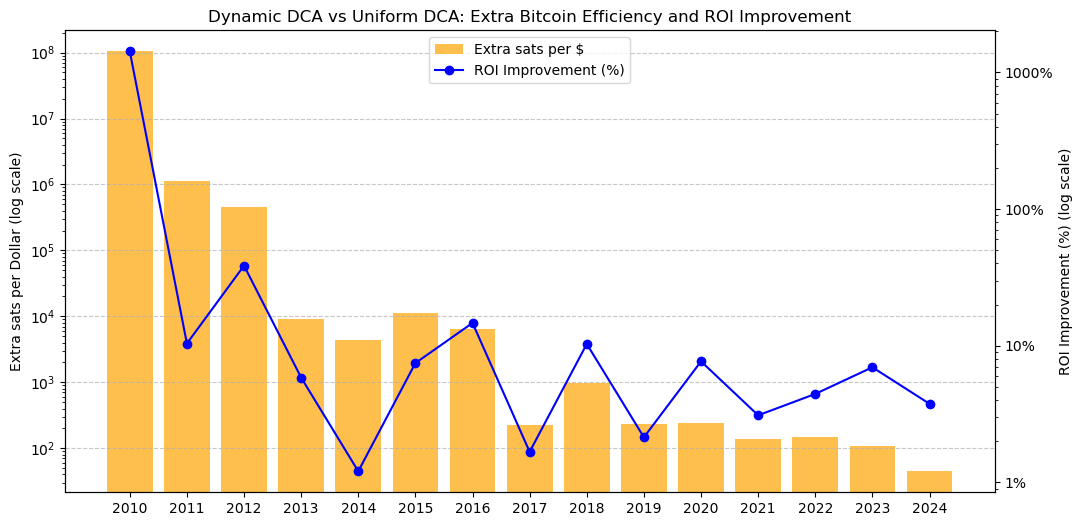

In [7]:
# Ensure the index is in datetime format
btc_df.index = pd.to_datetime(btc_df.index)

# Define the yearly cycle and set the budget (in USD)
cycle_length = pd.DateOffset(years=1)
start_date = btc_df.index.min()
end_date = btc_df.index.max()
budget = 100_000

# Initialize lists for analysis
cycle_labels = []
uniform_strategy_spd = []   # Uniform DCA: sats per $1 invested
dynamic_strategy_spd = []   # Dynamic DCA: sats per $1 invested
improvement_sats = []       # Extra sats per $1: dynamic - uniform
roi_uniform_list = []       # Uniform portfolio ROI (%)
roi_dynamic_list = []       # Dynamic portfolio ROI (%)
roi_improvement_pct = []    # ROI difference: dynamic ROI - uniform ROI

# Loop through each yearly cycle
current_start = start_date
while current_start <= end_date:
    current_end = min(current_start + cycle_length, end_date)
    cycle_df = btc_df.loc[current_start:current_end]
    if cycle_df.empty:
        break
    
    # Use the last available price in the cycle as the year-end price
    year_end_price = cycle_df['btc_close'].iloc[-1]
    
    # Uniform DCA: invest an equal amount each day
    dca_amount_per_day = budget / len(cycle_df)
    btc_dca_accumulated = (dca_amount_per_day / cycle_df['btc_close']).sum()  # in BTC
    # Compute uniform spd: sats per $1 invested
    uniform_spd = (btc_dca_accumulated / budget) * 100_000_000
    
    # Dynamic DCA: invest more when BTC is below its 200-day moving average
    moving_avg = cycle_df['btc_close'].rolling(window=200, min_periods=1).mean()
    undervaluation_factor = moving_avg / cycle_df['btc_close']
    dynamic_weights = 1 + (undervaluation_factor - undervaluation_factor.min()) / \
                         (undervaluation_factor.max() - undervaluation_factor.min())
    dynamic_dca_amounts = (budget / dynamic_weights.sum()) * dynamic_weights
    btc_dynamic_dca_accumulated = (dynamic_dca_amounts / cycle_df['btc_close']).sum()  # in BTC
    dynamic_spd = (btc_dynamic_dca_accumulated / budget) * 100_000_000
    
    # Store sats per dollar values
    cycle_labels.append(current_start.year)
    uniform_strategy_spd.append(uniform_spd)
    dynamic_strategy_spd.append(dynamic_spd)
    
    # Extra sats per $1
    extra_sats = dynamic_spd - uniform_spd
    improvement_sats.append(extra_sats)
    
    # Portfolio values at year-end (in USD)
    # Total sats acquired = spd * budget; convert sats to dollars via (year_end_price/100,000,000)
    uniform_value = (uniform_spd * budget) * (year_end_price / 100_000_000)
    dynamic_value = (dynamic_spd * budget) * (year_end_price / 100_000_000)
    
    # Compute ROI for each strategy: ((Portfolio Value - Budget)/Budget)*100
    uniform_roi = ((uniform_value - budget) / budget) * 100
    dynamic_roi = ((dynamic_value - budget) / budget) * 100
    roi_improvement = dynamic_roi - uniform_roi
    
    roi_uniform_list.append(uniform_roi)
    roi_dynamic_list.append(dynamic_roi)
    roi_improvement_pct.append(roi_improvement)
    
    # Move to the next cycle
    current_start += cycle_length

# Print the computed ROI improvements for each year
for year, roi_u, roi_d, roi_imp in zip(cycle_labels, roi_uniform_list, roi_dynamic_list, roi_improvement_pct):
    print(f"Year {year}: Uniform ROI = {roi_u:.2f}%, Dynamic ROI = {roi_d:.2f}%, ROI Improvement = {roi_imp:.2f}%")

# Plot the results: dual-axis plot with both metrics on log scale
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis: Extra sats per $ (log scale)
bars = ax1.bar(cycle_labels, improvement_sats, color='orange', alpha=0.7, label="Extra sats per $")
ax1.set_ylabel("Extra sats per Dollar (log scale)")
ax1.set_yscale("log")

ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Right y-axis: ROI improvement (%) (log scale)
ax2 = ax1.twinx()
ax2.plot(cycle_labels, roi_improvement_pct, marker='o', linestyle='-', color='blue', label="ROI Improvement (%)")
ax2.set_ylabel("ROI Improvement (%) (log scale)")
ax2.set_yscale("log")

# Format the right y-axis tick labels to show percentages instead of powers of 10
formatter = FuncFormatter(lambda x, pos: f"{x:.0f}%")
ax2.yaxis.set_major_formatter(formatter)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center")

ax1.set_title("Dynamic DCA vs Uniform DCA: Extra Bitcoin Efficiency and ROI Improvement")
plt.xticks(cycle_labels)
plt.show()

The bars (orange) represent the extra sats per dollar gained by the dynamic DCA strategy compared to uniform DCA, while the line (blue) shows the ROI improvement percentage if the sats were sold at the end of each year. Even with a relatively simple signal—buying more aggressively when Bitcoin’s price is below the 200-day moving average—we see a notable boost in both sats per dollar and overall returns. This illustrates how a basic dynamic adjustment can outperform uniform DCA without sacrificing its core benefits of steady accumulation and reduced emotional bias, making it a dominant strategy.


Cycle 2010-2014: Uniform ROI = 88021.71%, Dynamic ROI = 89114.46%, ROI Improvement = 1092.74%
Cycle 2014-2018: Uniform ROI = 1254.28%, Dynamic ROI = 1318.29%, ROI Improvement = 64.02%
Cycle 2018-2022: Uniform ROI = 112.30%, Dynamic ROI = 121.77%, ROI Improvement = 9.47%
Cycle 2022-2025: Uniform ROI = 144.81%, Dynamic ROI = 155.77%, ROI Improvement = 10.96%


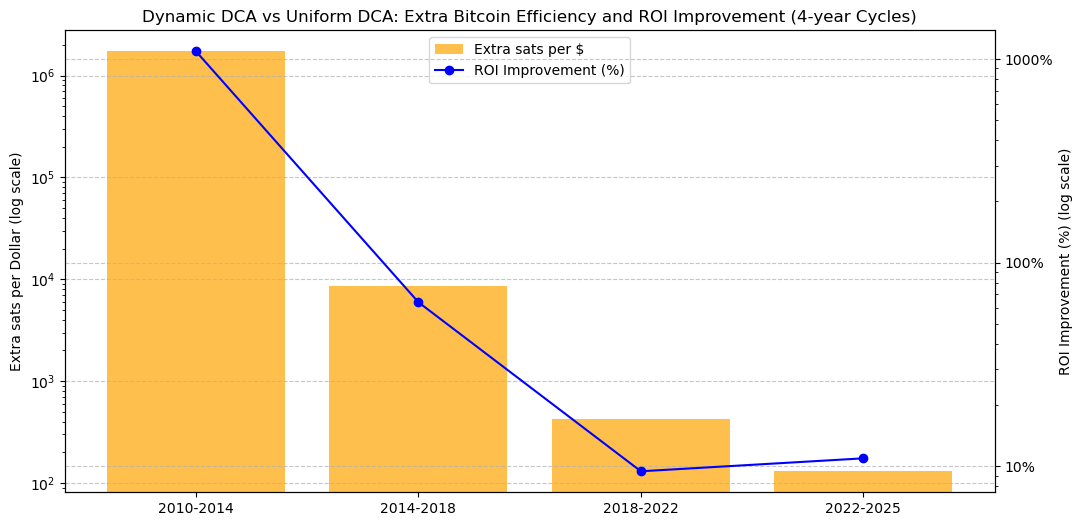

In [9]:
# Ensure the index is in datetime format
btc_df.index = pd.to_datetime(btc_df.index)

# Define the 4-year cycle and set the budget (in USD)
cycle_length = pd.DateOffset(years=4)
start_date = btc_df.index.min()
end_date = btc_df.index.max()
budget = 100_000

# Initialize lists for analysis
cycle_labels = []
uniform_strategy_spd = []   # Uniform DCA: sats per $1 invested
dynamic_strategy_spd = []   # Dynamic DCA: sats per $1 invested
improvement_sats = []       # Extra sats per $1: dynamic - uniform
roi_uniform_list = []       # Uniform portfolio ROI (%)
roi_dynamic_list = []       # Dynamic portfolio ROI (%)
roi_improvement_pct = []    # ROI difference: dynamic ROI - uniform ROI

# Loop through each 4-year cycle
current_start = start_date
while current_start <= end_date:
    current_end = min(current_start + cycle_length, end_date)
    cycle_df = btc_df.loc[current_start:current_end]
    if cycle_df.empty:
        break
    
    # Label the cycle as "startYear-endYear"
    cycle_labels.append(f"{current_start.year}-{current_end.year}")
    
    # Use the last available price in the cycle as the end-cycle price
    cycle_end_price = cycle_df['btc_close'].iloc[-1]
    
    # Uniform DCA: invest an equal amount each day
    dca_amount_per_day = budget / len(cycle_df)
    btc_dca_accumulated = (dca_amount_per_day / cycle_df['btc_close']).sum()  # in BTC
    # Compute uniform spd: sats per $1 invested
    uniform_spd = (btc_dca_accumulated / budget) * 100_000_000
    
    # Dynamic DCA: invest more when BTC is below its 200-day moving average
    moving_avg = cycle_df['btc_close'].rolling(window=200, min_periods=1).mean()
    undervaluation_factor = moving_avg / cycle_df['btc_close']
    dynamic_weights = 1 + (undervaluation_factor - undervaluation_factor.min()) / \
                         (undervaluation_factor.max() - undervaluation_factor.min())
    dynamic_dca_amounts = (budget / dynamic_weights.sum()) * dynamic_weights
    btc_dynamic_dca_accumulated = (dynamic_dca_amounts / cycle_df['btc_close']).sum()  # in BTC
    dynamic_spd = (btc_dynamic_dca_accumulated / budget) * 100_000_000
    
    # Store sats per dollar values
    uniform_strategy_spd.append(uniform_spd)
    dynamic_strategy_spd.append(dynamic_spd)
    
    # Extra sats per $1
    extra_sats = dynamic_spd - uniform_spd
    improvement_sats.append(extra_sats)
    
    # Portfolio values at cycle-end (in USD)
    # Total sats acquired = spd * budget; convert sats to dollars via (cycle_end_price/100_000_000)
    uniform_value = (uniform_spd * budget) * (cycle_end_price / 100_000_000)
    dynamic_value = (dynamic_spd * budget) * (cycle_end_price / 100_000_000)
    
    # Compute ROI for each strategy: ((Portfolio Value - Budget)/Budget)*100
    uniform_roi = ((uniform_value - budget) / budget) * 100
    dynamic_roi = ((dynamic_value - budget) / budget) * 100
    roi_improvement = dynamic_roi - uniform_roi
    
    roi_uniform_list.append(uniform_roi)
    roi_dynamic_list.append(dynamic_roi)
    roi_improvement_pct.append(roi_improvement)
    
    # Move to the next cycle
    current_start += cycle_length

# Print the computed ROI improvements for each 4-year cycle
for label, roi_u, roi_d, roi_imp in zip(cycle_labels, roi_uniform_list, roi_dynamic_list, roi_improvement_pct):
    print(f"Cycle {label}: Uniform ROI = {roi_u:.2f}%, Dynamic ROI = {roi_d:.2f}%, ROI Improvement = {roi_imp:.2f}%")

# Plot the results: dual-axis plot with both metrics on log scale
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis: Extra sats per $1 (log scale)
bars = ax1.bar(cycle_labels, improvement_sats, color='orange', alpha=0.7, label="Extra sats per $")
ax1.set_ylabel("Extra sats per Dollar (log scale)")
ax1.set_yscale("log")
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Right y-axis: ROI improvement (%) (log scale)
ax2 = ax1.twinx()
ax2.plot(cycle_labels, roi_improvement_pct, marker='o', linestyle='-', color='blue', label="ROI Improvement (%)")
ax2.set_ylabel("ROI Improvement (%) (log scale)")
ax2.set_yscale("log")

# Format the right y-axis tick labels to show percentages instead of powers of 10
formatter = FuncFormatter(lambda x, pos: f"{x:.0f}%")
ax2.yaxis.set_major_formatter(formatter)

# Add grid lines on the right y-axis for each ROI tick
ax2.yaxis.grid(True, which='major', linestyle='--', alpha=0.7)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center")

ax1.set_title("Dynamic DCA vs Uniform DCA: Extra Bitcoin Efficiency and ROI Improvement (4-year Cycles)")
plt.xticks(rotation=45)
plt.show()

# Closing Remarks

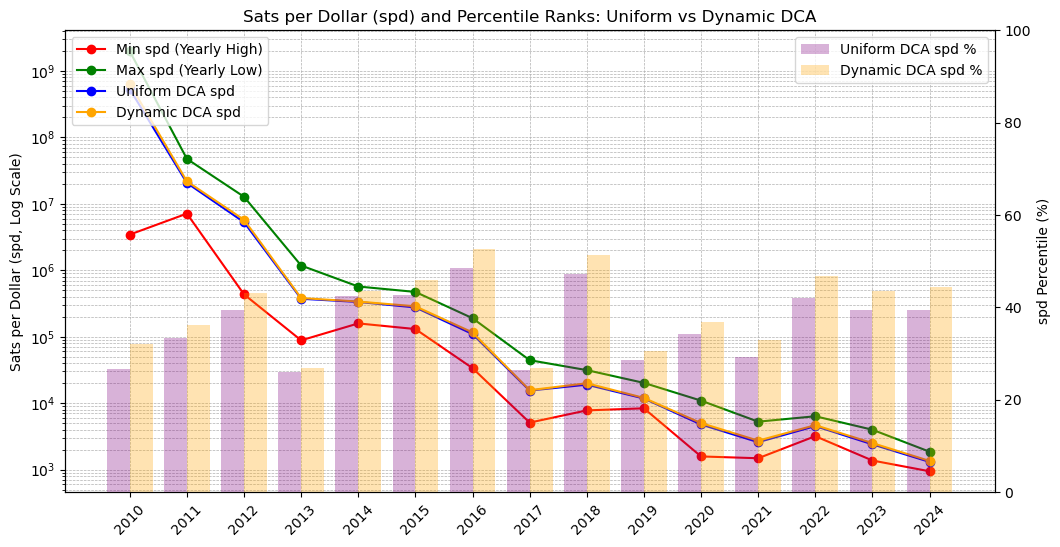

In [11]:
# Ensure the index is in datetime format
btc_df.index = pd.to_datetime(btc_df.index)

# Define the yearly cycle
cycle_length = pd.DateOffset(years=1)
start_date = btc_df.index.min()
end_date = btc_df.index.max()

# Budget per year
budget = 100_000

# Initialize lists for plotting
cycle_labels = []
min_spd_pct_list = []   # spd when buying at yearly high (worst-case)
max_spd_pct_list = []   # spd when buying at yearly low (best-case)
uniform_strategy_spd = []   # Uniform DCA spd value
dynamic_strategy_spd = []   # Dynamic DCA spd value
uniform_spd_pct = []    # Normalized percentile for Uniform DCA
dynamic_spd_pct = []    # Normalized percentile for Dynamic DCA

# Loop through each yearly cycle
current_start = start_date
while current_start <= end_date:
    current_end = min(current_start + cycle_length, end_date)
    cycle_df = btc_df.loc[current_start:current_end]

    if cycle_df.empty:
        break

    # Yearly high and low prices
    year_high = cycle_df['btc_close'].max()  # Worst-case price
    year_low = cycle_df['btc_close'].min()   # Best-case price

    # Define min and max spd (sats per dollar) for the cycle
    min_spd_pct_val = (1 / year_high) * 100_000_000  # Minimum spd (buying at highest price)
    max_spd_pct_val = (1 / year_low) * 100_000_000     # Maximum spd (buying at lowest price)

    # Uniform DCA: Equal spend per day
    dca_amount_per_day = budget / len(cycle_df)
    btc_dca_accumulated = (dca_amount_per_day / cycle_df['btc_close']).sum()
    uniform_spd = (btc_dca_accumulated / budget) * 100_000_000

    # Dynamic DCA: Buys more when BTC is below the 200-day MA
    moving_avg = cycle_df['btc_close'].rolling(window=200, min_periods=1).mean()
    undervaluation_factor = moving_avg / cycle_df['btc_close']
    dynamic_weights = 1 + (undervaluation_factor - undervaluation_factor.min()) / \
                         (undervaluation_factor.max() - undervaluation_factor.min())
    dynamic_dca_amounts = (budget / dynamic_weights.sum()) * dynamic_weights
    btc_dynamic_dca_accumulated = (dynamic_dca_amounts / cycle_df['btc_close']).sum()
    dynamic_spd = (btc_dynamic_dca_accumulated / budget) * 100_000_000

    # Normalize to get spd percentile for each strategy:
    # 0% => spd = min_spd_pct_val (worst-case); 100% => spd = max_spd_pct_val (best-case)
    uniform_pct = ((uniform_spd - min_spd_pct_val) / (max_spd_pct_val - min_spd_pct_val)) * 100
    dynamic_pct = ((dynamic_spd - min_spd_pct_val) / (max_spd_pct_val - min_spd_pct_val)) * 100

    # Store values for plotting
    cycle_labels.append(current_start.year)
    min_spd_pct_list.append(min_spd_pct_val)
    max_spd_pct_list.append(max_spd_pct_val)
    uniform_strategy_spd.append(uniform_spd)
    dynamic_strategy_spd.append(dynamic_spd)
    uniform_spd_pct.append(uniform_pct)
    dynamic_spd_pct.append(dynamic_pct)

    # Move to next cycle
    current_start += cycle_length

# Plot the results
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary Y-axis: spd values (Sats per Dollar) on a log scale
ax1.set_yscale("log")
ax1.plot(cycle_labels, min_spd_pct_list, marker='o', linestyle='-', label="Min spd (Yearly High)", color='red')
ax1.plot(cycle_labels, max_spd_pct_list, marker='o', linestyle='-', label="Max spd (Yearly Low)", color='green')
ax1.plot(cycle_labels, uniform_strategy_spd, marker='o', linestyle='-', label="Uniform DCA spd", color='blue')
ax1.plot(cycle_labels, dynamic_strategy_spd, marker='o', linestyle='-', label="Dynamic DCA spd", color='orange')

ax1.set_ylabel("Sats per Dollar (spd, Log Scale)")
ax1.set_title("Sats per Dollar (spd) and Percentile Ranks: Uniform vs Dynamic DCA")
ax1.legend(loc="upper left")
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.set_xticks(cycle_labels)
ax1.set_xticklabels(cycle_labels, rotation=45)

# Secondary Y-axis: spd Percentile Rank
ax2 = ax1.twinx()
bar_width = 0.4

ax2.bar(
    [x - bar_width/2 for x in cycle_labels],
    uniform_spd_pct,
    width=bar_width,
    alpha=0.3,
    color='purple',
    label="Uniform DCA spd %"
)

ax2.bar(
    [x + bar_width/2 for x in cycle_labels],
    dynamic_spd_pct,
    width=bar_width,
    alpha=0.3,
    color='orange',
    label="Dynamic DCA spd %"
)

ax2.set_ylabel("spd Percentile (%)")
ax2.set_ylim(0, 100)
ax2.legend(loc="upper right")

plt.show()

We believe you can find Dynamic DCA strategies that outperform this one. The methodology involves understanding Bitcoin's structural characteristics and leveraging them to achieve a higher spd percentile.